<a href="https://colab.research.google.com/github/pawelszajwaj/Segregation/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pobranie z githuba plików audio

In [1]:
!git clone https://github.com/pawelszajwaj/Segregation.git

Cloning into 'Segregation'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 559 (delta 48), reused 102 (delta 27), pack-reused 395
Receiving objects: 100% (559/559), 821.68 MiB | 29.82 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Updating files: 100% (79/79), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
!pip install tensorflow-io
import tensorflow_io as tfio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 50.8 MB/s eta 0:00:00


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout

In [6]:
!mkdir AudioFiles
!mkdir AudioFiles/Good
!mkdir AudioFiles/Bad

In [ ]:
!unzip '/content/Segregation/AudioFiles/5seconds/Good/*.zip' -d '/content/AudioFiles/Good'
!unzip '/content/Segregation/AudioFiles/5seconds/Bad/*.zip' -d '/content/AudioFiles/Bad'

#if os.path.exists("/content/AudioFiles/Bad/13.1.21.wav"):
#  os.remove("/content/AudioFiles/Bad/13.1.21.wav")



Archive:  /content/Segregation/AudioFiles/5seconds/Good/5_seconds_1-5.zip
  inflating: /content/AudioFiles/Good/5.1.12.wav  
  inflating: /content/AudioFiles/Good/1.1.1.wav  
  inflating: /content/AudioFiles/Good/1.1.2.wav  
  inflating: /content/AudioFiles/Good/1.1.3.wav  
  inflating: /content/AudioFiles/Good/1.1.4.wav  
  inflating: /content/AudioFiles/Good/1.1.5.wav  
  inflating: /content/AudioFiles/Good/1.1.6.wav  
  inflating: /content/AudioFiles/Good/1.1.7.wav  
  inflating: /content/AudioFiles/Good/1.1.8.wav  
  inflating: /content/AudioFiles/Good/1.1.9.wav  
  inflating: /content/AudioFiles/Good/1.1.10.wav  
  inflating: /content/AudioFiles/Good/1.1.11.wav  
  inflating: /content/AudioFiles/Good/1.1.12.wav  
  inflating: /content/AudioFiles/Good/2.1.1.wav  
  inflating: /content/AudioFiles/Good/2.1.2.wav  
  inflating: /content/AudioFiles/Good/2.1.3.wav  
  inflating: /content/AudioFiles/Good/2.1.4.wav  
  inflating: /content/AudioFiles/Good/2.1.5.wav  
  inflating: /content/

In [ ]:
audio_files = glob('/content/AudioFiles/*/*.wav')
audio_files_good = glob('/content/AudioFiles/Good/*.wav')
audio_files_bad = glob('/content/AudioFiles/Bad/*.wav')

In [7]:
def load_wav_16k_mono(filename):
  file_contents = tf.io.read_file(filename)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype = tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

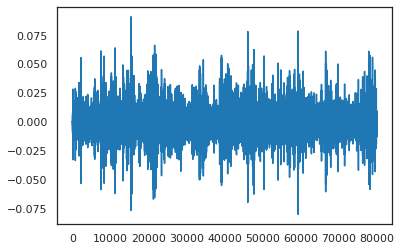

In [ ]:
wav = load_wav_16k_mono(audio_files_bad[0])
wav = load_wav_16k_mono(audio_files_good[0])
plt.plot(wav.numpy())

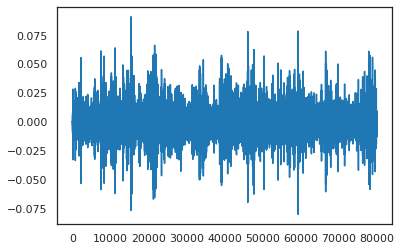

In [ ]:
wav = tf.cast(wav, tf.float32)
plt.figure()
plt.plot(wav.numpy())

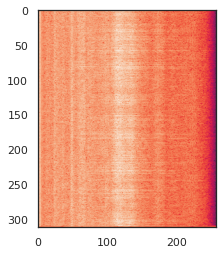

In [ ]:
spectrogram = tfio.audio.spectrogram(
    wav, nfft=512, window=512, stride=256)
plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

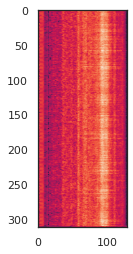

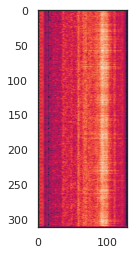

In [ ]:
mel_spectrogram = tfio.audio.melscale(
  spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
dbscale_mel_spectrogram = tfio.audio.dbscale(
  mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

In [ ]:
good = tf.data.Dataset.list_files('/content/AudioFiles/Good/*.wav')
bad = tf.data.Dataset.list_files('/content/AudioFiles/Bad/*.wav')
good.as_numpy_iterator().next()

b'/content/AudioFiles/Good/3.1.12.wav'

In [ ]:
positives = tf.data.Dataset.zip((good, tf.data.Dataset.from_tensor_slices(tf.ones(len(good)))))
negatives = tf.data.Dataset.zip((bad, tf.data.Dataset.from_tensor_slices(tf.zeros(len(good)))))
data = positives.concatenate(negatives)
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/AudioFiles/Good/6.1.11.wav', 1.0)

In [71]:
positives = tf.data.Dataset.zip((goodZ, tf.data.Dataset.from_tensor_slices(tf.ones(len(goodZ)))))
negatives = tf.data.Dataset.zip((badZ, tf.data.Dataset.from_tensor_slices(tf.zeros(len(badZ)))))
data = positives.concatenate(negatives)
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/AudioFiles/Bad/14.12.Z.wav', 0.0)

In [8]:
def preprocess(file_path, label):
  wav = load_wav_16k_mono(file_path)
  wav = tf.cast(wav, tf.float32)
  spectrogram = tfio.audio.spectrogram(
    wav, nfft=512, window=512, stride=256)
  spectrogram = tf.abs(spectrogram)
  mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
  dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)
  dbscale_mel_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=2)
  return dbscale_mel_spectrogram, label

In [72]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [73]:
print(len(data))
train = data.take(10)
test = data.skip(10).take(6)

17


In [65]:
print(len(data))
train = data.take(12)
test = data.skip(12).take(5)

17


In [46]:
samples, labels = train.as_numpy_iterator().next()

In [47]:
samples.shape

(16, 313, 128, 1)

In [48]:
labels

array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [56]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

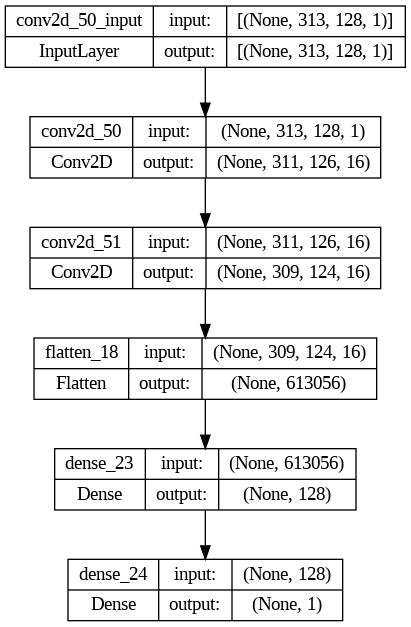

In [57]:
model.compile("Adam", loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [51]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 311, 126, 16)      160       
                                                                 
 conv2d_49 (Conv2D)          (None, 309, 124, 16)      2320      
                                                                 
 flatten_17 (Flatten)        (None, 613056)            0         
                                                                 
 dense_21 (Dense)            (None, 128)               78471296  
                                                                 
 dense_22 (Dense)            (None, 1)                 129       
                                                                 
Total params: 78,473,905
Trainable params: 78,473,905
Non-trainable params: 0
_________________________________________________________________


In [74]:
hist = model.fit(train, epochs=3, validation_data=test)

Epoch 1/3
10/10 [==============================] - 33s 2s/step - loss: 0.5365 - recall_1: 0.7746 - precision_1: 0.7639 - val_loss: 0.2195 - val_recall_1: 0.9333 - val_precision_1: 0.8750
Epoch 2/3
10/10 [==============================] - 23s 2s/step - loss: 0.1313 - recall_1: 0.9444 - precision_1: 0.9315 - val_loss: 0.1159 - val_recall_1: 0.8750 - val_precision_1: 1.0000
Epoch 3/3
10/10 [==============================] - 31s 3s/step - loss: 0.0868 - recall_1: 0.9538 - precision_1: 0.9841 - val_loss: 0.0526 - val_recall_1: 0.9767 - val_precision_1: 1.0000


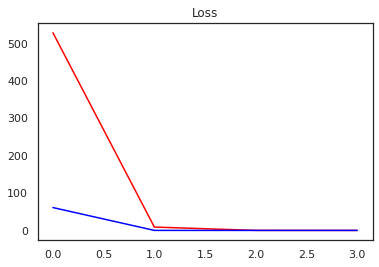

In [ ]:
plt.title("Loss")
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'],'b')
plt.show()

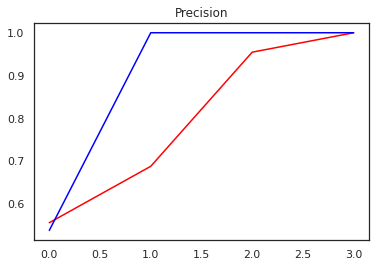

In [ ]:
plt.title("Precision")
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'],'b')
plt.show()

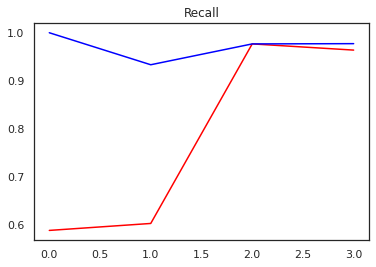

In [ ]:
plt.title("Recall")
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'],'b')
plt.show()

In [75]:
# WIELKI TEST
X_test, y_test = test.as_numpy_iterator().next()

In [76]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 314ms/step


In [ ]:
yhat

array([[1.1610431e-11],
       [2.7547368e-28],
       [2.6993445e-20],
       [9.9999994e-01],
       [2.5753836e-05],
       [1.2312714e-35],
       [3.3550328e-01],
       [0.0000000e+00],
       [9.9880159e-01],
       [9.9931055e-01],
       [1.0000000e+00],
       [9.9993289e-01],
       [9.9999875e-01],
       [9.9994427e-01],
       [9.9999976e-01],
       [9.9999309e-01]], dtype=float32)

In [ ]:
y_test  ## ewidentnie przetretnowany

array([0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [77]:
yhat = np.array(np.hstack(yhat), dtype=int)
y_test = np.array(np.hstack(y_test), dtype=int)
print(np.hstack(yhat))
print(y_test)     # troche beznadziejnie  - czyzby z=samym audio sie nei dalo?
             

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1]


# Tu sprawdzimy, czy inny podział ma sens. 

Podzielimy dane na 2 rodzaje danych:
 - pierwsza grupa to te ewidetnie złe vs reszta 
 - druga to to srednie vs te dobre. 
 
Podział zostanie przeprowadzony zgodnie z przyjetymi zalozeniami, tj. 1-10 dobre, 11-23 złe


In [ ]:
!mkdir AudioFilesVar
!mkdir AudioFilesVar/Good
!mkdir AudioFilesVar/Bad
!mkdir AudioFilesVar/Mid
!mkdir AudioFilesVar/Good_and_Mid

In [ ]:
!unzip '/content/Segregation/AudioFilesVar/5seconds/Good/*.zip' -d '/content/AudioFilesVar/Good'
!unzip '/content/Segregation/AudioFilesVar/5seconds/Bad/*.zip' -d '/content/AudioFilesVar/Bad'
!unzip '/content/Segregation/AudioFilesVar/5seconds/Mid/*.zip' -d '/content/AudioFilesVar/Mid'
!unzip '/content/Segregation/AudioFilesVar/5seconds/Mid/*.zip' -d '/content/AudioFilesVar/Good_and_Mid'
!unzip '/content/Segregation/AudioFilesVar/5seconds/Good/*.zip' -d '/content/AudioFilesVar/Good_and_Mid'


if os.path.exists("/content/AudioFilesVar/Bad/13.1.21 - bad file!.wav"):
  os.remove("/content/AudioFilesVar/Bad/13.1.21 - bad file!.wav")
if os.path.exists("/content/AudioFilesVar/Mid/13.1.21 - bad file!.wav"):
  os.remove("/content/AudioFilesVar/Mid/13.1.21 - bad file!.wav")
if os.path.exists("/content/AudioFilesVar/Good_and_Mid/13.1.21 - bad file!.wav"):
  os.remove("/content/AudioFilesVar/Good_and_Mid/13.1.21 - bad file!.wav")

Archive:  /content/Segregation/AudioFilesVar/5seconds/Good/5_seconds_1-5.zip
  inflating: /content/AudioFilesVar/Good/5.1.12.wav  
  inflating: /content/AudioFilesVar/Good/1.1.1.wav  
  inflating: /content/AudioFilesVar/Good/1.1.2.wav  
  inflating: /content/AudioFilesVar/Good/1.1.3.wav  
  inflating: /content/AudioFilesVar/Good/1.1.4.wav  
  inflating: /content/AudioFilesVar/Good/1.1.5.wav  
  inflating: /content/AudioFilesVar/Good/1.1.6.wav  
  inflating: /content/AudioFilesVar/Good/1.1.7.wav  
  inflating: /content/AudioFilesVar/Good/1.1.8.wav  
  inflating: /content/AudioFilesVar/Good/1.1.9.wav  
  inflating: /content/AudioFilesVar/Good/1.1.10.wav  
  inflating: /content/AudioFilesVar/Good/1.1.11.wav  
  inflating: /content/AudioFilesVar/Good/1.1.12.wav  
  inflating: /content/AudioFilesVar/Good/2.1.1.wav  
  inflating: /content/AudioFilesVar/Good/2.1.2.wav  
  inflating: /content/AudioFilesVar/Good/2.1.3.wav  
  inflating: /content/AudioFilesVar/Good/2.1.4.wav  
  inflating: /cont

In [ ]:
audio_files_var = glob('/content/AudioFilesVar/*/*.wav')
audio_files_var_good = glob('/content/AudioFilesVar/Good/*.wav')
audio_files_var_bad = glob('/content/AudioFilesVar/Bad/*.wav')
audio_files_var_mid = glob('/content/AudioFilesVar/Mid/*.wav')
audio_files_var_good_and_bad = glob('/content/AudioFilesVar/{Good,Mid}/*.wav')

In [ ]:
goodmidvar = tf.data.Dataset.list_files('/content/AudioFilesVar/Good_and_Mid/*.wav')
badvar = tf.data.Dataset.list_files('/content/AudioFilesVar/Bad/*.wav')
goodvar = tf.data.Dataset.list_files('/content/AudioFilesVar/Good/*.wav')
midvar = tf.data.Dataset.list_files('/content/AudioFilesVar/Mid/*.wav')
good.as_numpy_iterator().next()

b'/content/AudioFiles/Good/10.1.13.wav'

In [ ]:
positives = tf.data.Dataset.zip((goodmidvar, tf.data.Dataset.from_tensor_slices(tf.ones(len(good)))))
negatives = tf.data.Dataset.zip((badvar, tf.data.Dataset.from_tensor_slices(tf.zeros(len(good)))))
datavar1 = positives.concatenate(negatives)
datavar1.shuffle(1000).as_numpy_iterator().next()

(b'/content/AudioFilesVar/Bad/14.1.3.wav', 0.0)

In [ ]:
datavar1 = datavar1.map(preprocess)
datavar1 = datavar1.cache()
datavar1 = datavar1.shuffle(buffer_size=1000)
datavar1 = datavar1.batch(16)
datavar1 = datavar1.prefetch(8)

In [ ]:
print(len(datavar1))
train = datavar1.take(8)
test = datavar1.skip(8).take(4)

12


In [ ]:
modelvar1 = Sequential()
modelvar1.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
modelvar1.add(Conv2D(16, (3,3), activation='relu'))
modelvar1.add(Flatten())
modelvar1.add(Dense(128, activation='relu'))
modelvar1.add(Dense(1, activation='sigmoid'))

In [ ]:
modelvar1.compile("Adam", loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 311, 126, 16)      160       
                                                                 
 conv2d_24 (Conv2D)          (None, 309, 124, 16)      2320      
                                                                 
 flatten_11 (Flatten)        (None, 613056)            0         
                                                                 
 dense_12 (Dense)            (None, 128)               78471296  
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 78,473,905
Trainable params: 78,473,905
Non-trainable params: 0
_________________________________________________________________


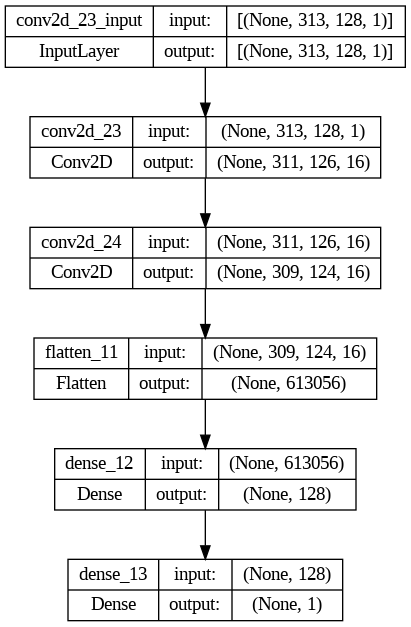

In [ ]:
modelvar1.summary()
keras.utils.plot_model(modelvar1, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
histvar1 = modelvar1.fit(train, epochs=4, validation_data=test)

Epoch 1/4
8/8 [==============================] - 26s 3s/step - loss: 545.4633 - recall_3: 0.7356 - precision_3: 0.6882 - val_loss: 316.8904 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00
Epoch 2/4
8/8 [==============================] - 17s 2s/step - loss: 95.4408 - recall_3: 0.6625 - precision_3: 0.8983 - val_loss: 39.7846 - val_recall_3: 1.0000 - val_precision_3: 0.8043
Epoch 3/4
8/8 [==============================] - 19s 2s/step - loss: 42.2155 - recall_3: 0.9767 - precision_3: 0.8077 - val_loss: 7.1609 - val_recall_3: 0.7105 - val_precision_3: 1.0000
Epoch 4/4
8/8 [==============================] - 17s 2s/step - loss: 5.6935 - recall_3: 0.7024 - precision_3: 1.0000 - val_loss: 4.6237e-19 - val_recall_3: 1.0000 - val_precision_3: 1.0000


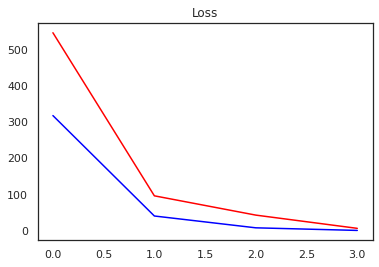

In [ ]:
plt.title("Loss")
plt.plot(histvar1.history['loss'], 'r')
plt.plot(histvar1.history['val_loss'],'b')
plt.show()

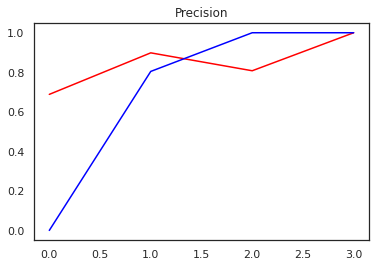

In [ ]:
plt.title("Precision")
plt.plot(histvar1.history['precision_3'], 'r')
plt.plot(histvar1.history['val_precision_3'],'b')
plt.show()

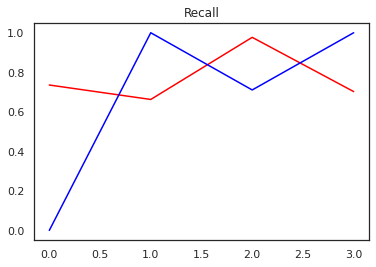

In [ ]:
plt.title("Recall")
plt.plot(histvar1.history['recall_3'], 'r')
plt.plot(histvar1.history['val_recall_3'],'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = modelvar1.predict(X_test)

1/1 [==============================] - 0s 358ms/step


In [ ]:
yhat = np.array(np.hstack(yhat), dtype=int)
y_test = np.array(np.hstack(y_test), dtype=int)

In [ ]:
print(np.hstack(yhat))
print(y_test)

[0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1]
[0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1]


# PIERWSZY PODZIAŁ WYADJE SIĘ SESOWNY. TERAZ, GDY ODRZUCILIŚMY JUŻ TE NA 100% ZŁE, CZAS NA LEKKO SUBTELNIJSZY PODZIAŁ, CZYLI NA GOOD VS MID

In [ ]:
positives = tf.data.Dataset.zip((goodvar, tf.data.Dataset.from_tensor_slices(tf.ones(len(good)))))
negatives = tf.data.Dataset.zip((midvar, tf.data.Dataset.from_tensor_slices(tf.zeros(len(good)))))
datavar2 = positives.concatenate(negatives)
datavar2.shuffle(1000).as_numpy_iterator().next()

(b'/content/AudioFilesVar/Good/3.1.9.wav', 1.0)

In [ ]:
datavar2 = datavar2.map(preprocess)
datavar2 = datavar2.cache()
datavar2 = datavar2.shuffle(buffer_size=1000)
datavar2 = datavar2.batch(16)
datavar2 = datavar2.prefetch(8)

In [ ]:
print(len(datavar2))
train = datavar2.take(10)
test = datavar2.skip(4).take(4)

14


In [9]:
from tensorflow.keras.constraints import MaxNorm

In [ ]:
modelvar2 = Sequential()
modelvar2.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
modelvar2.add(Conv2D(16, (3,3), activation='relu'))
modelvar2.add(Dropout(0.2))
modelvar2.add(Flatten())
modelvar2.add(Dense(128, activation='relu', kernel_constraint=MaxNorm(1.)))
modelvar2.add(Dense(1, activation='sigmoid'))

In [ ]:
modelvar2.compile("Adam", loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
modelvar2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 311, 126, 16)      160       
                                                                 
 conv2d_22 (Conv2D)          (None, 309, 124, 16)      2320      
                                                                 
 dropout_9 (Dropout)         (None, 309, 124, 16)      0         
                                                                 
 flatten_10 (Flatten)        (None, 613056)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               78471296  
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 78,473,905
Trainable params: 78,473,905

In [ ]:
histvar2 = modelvar2.fit(train, epochs=3, validation_data=test)

Epoch 1/3
10/10 [==============================] - 33s 3s/step - loss: 183.3426 - recall_5: 0.6333 - precision_5: 0.6404 - val_loss: 24.0791 - val_recall_5: 1.0000 - val_precision_5: 0.5000
Epoch 2/3
10/10 [==============================] - 30s 3s/step - loss: 6.8543 - recall_5: 0.6180 - precision_5: 0.6707 - val_loss: 0.2682 - val_recall_5: 1.0000 - val_precision_5: 0.9535
Epoch 3/3
10/10 [==============================] - 28s 3s/step - loss: 0.3387 - recall_5: 0.9787 - precision_5: 0.8932 - val_loss: 0.2515 - val_recall_5: 0.9211 - val_precision_5: 0.9722


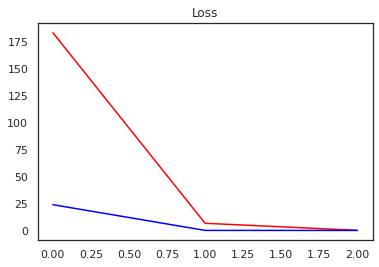

In [ ]:
plt.title("Loss")
plt.plot(histvar2.history['loss'], 'r')
plt.plot(histvar2.history['val_loss'],'b')
plt.show()

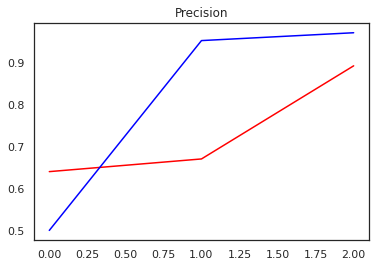

In [ ]:
plt.title("Precision")
plt.plot(histvar2.history['precision_5'], 'r')
plt.plot(histvar2.history['val_precision_5'],'b')
plt.show()

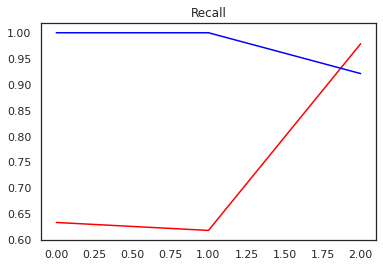

In [ ]:
plt.title("Recall")
plt.plot(histvar2.history['recall_5'], 'r')
plt.plot(histvar2.history['val_recall_5'],'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = modelvar2.predict(X_test)

1/1 [==============================] - 0s 339ms/step


In [ ]:
yhat = np.array(np.hstack(yhat), dtype=int)
y_test = np.array(np.hstack(y_test), dtype=int)

In [ ]:
print(np.hstack(yhat))
print(y_test)     # troche beznadziejnie  - czyzby z=samym audio sie nei dalo?
                  # dropout layer dodaje jakies 2/3 dobre trafienia
                  # po dodainu normalizaci =1 do dense layaer znowu nic nie dziala

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1]


**CZAS NA 4-x input! tak, bedziemy dawac wsio -> audio + dragnia xyz. 
Pytanie - czy potrzebujhemy wszystkie kierunki?t**

In [10]:
!unzip '/content/Segregation/AudioFiles/5secondsvibro/Good/*.zip' -d '/content/AudioFiles/Good'
!unzip '/content/Segregation/AudioFiles/5secondsvibro/Bad/*.zip' -d '/content/AudioFiles/Bad'

Archive:  /content/Segregation/AudioFiles/5secondsvibro/Good/7.zip
  inflating: /content/AudioFiles/Good/7.11.Z.wav  
  inflating: /content/AudioFiles/Good/7.1.Audio.wav  
  inflating: /content/AudioFiles/Good/7.1.X.wav  
  inflating: /content/AudioFiles/Good/7.1.Y.wav  
  inflating: /content/AudioFiles/Good/7.1.Z.wav  
  inflating: /content/AudioFiles/Good/7.2.Audio.wav  
  inflating: /content/AudioFiles/Good/7.2.X.wav  
  inflating: /content/AudioFiles/Good/7.2.Y.wav  
  inflating: /content/AudioFiles/Good/7.2.Z.wav  
  inflating: /content/AudioFiles/Good/7.3.Audio.wav  
  inflating: /content/AudioFiles/Good/7.3.X.wav  
  inflating: /content/AudioFiles/Good/7.3.Y.wav  
  inflating: /content/AudioFiles/Good/7.3.Z.wav  
  inflating: /content/AudioFiles/Good/7.4.Audio.wav  
  inflating: /content/AudioFiles/Good/7.4.X.wav  
  inflating: /content/AudioFiles/Good/7.4.Y.wav  
  inflating: /content/AudioFiles/Good/7.4.Z.wav  
  inflating: /content/AudioFiles/Good/7.5.Audio.wav  
  inflating:

In [11]:
def preprocess(file_path, label):
  wav = load_wav_16k_mono(file_path)
  wav = tf.cast(wav, tf.float32)
  spectrogram = tfio.audio.spectrogram(
    wav, nfft=512, window=512, stride=256)
  spectrogram = tf.abs(spectrogram)
  mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
  dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)
  dbscale_mel_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=2)
  return dbscale_mel_spectrogram, label

In [12]:
goodA = tf.data.Dataset.list_files('/content/AudioFiles/Good/*.Audio.wav')
goodX = tf.data.Dataset.list_files('/content/AudioFiles/Good/*.X.wav')
goodY = tf.data.Dataset.list_files('/content/AudioFiles/Good/*.Y.wav')
goodZ = tf.data.Dataset.list_files('/content/AudioFiles/Good/*.Z.wav')
badA = tf.data.Dataset.list_files('/content/AudioFiles/Bad/*.Audio.wav')
badX = tf.data.Dataset.list_files('/content/AudioFiles/Bad/*.X.wav')
badY = tf.data.Dataset.list_files('/content/AudioFiles/Bad/*.Y.wav')
badZ = tf.data.Dataset.list_files('/content/AudioFiles/Bad/*.Z.wav')


In [ ]:
goodA.as_numpy_iterator().next()

b'/content/AudioFiles/Good/9.11.Audio.wav'

In [13]:
positivesA = tf.data.Dataset.zip((goodA, tf.data.Dataset.from_tensor_slices(tf.ones(len(goodA)))))
negativesA = tf.data.Dataset.zip((badA, tf.data.Dataset.from_tensor_slices(tf.zeros(len(badA)))))
dataA = positivesA.concatenate(negativesA)

positivesX = tf.data.Dataset.zip((goodX, tf.data.Dataset.from_tensor_slices(tf.ones(len(goodX)))))
negativesX = tf.data.Dataset.zip((badX, tf.data.Dataset.from_tensor_slices(tf.zeros(len(badX)))))
dataX = positivesX.concatenate(negativesX)

positivesY = tf.data.Dataset.zip((goodY, tf.data.Dataset.from_tensor_slices(tf.ones(len(goodY)))))
negativesY = tf.data.Dataset.zip((badY, tf.data.Dataset.from_tensor_slices(tf.zeros(len(badY)))))
dataY = positivesY.concatenate(negativesY)

positivesZ = tf.data.Dataset.zip((goodZ, tf.data.Dataset.from_tensor_slices(tf.ones(len(goodZ)))))
negativesZ = tf.data.Dataset.zip((badZ, tf.data.Dataset.from_tensor_slices(tf.zeros(len(badZ)))))
dataZ = positivesZ.concatenate(negativesZ)

In [14]:
dataA = dataA.map(preprocess)
dataA = dataA.cache()
dataA = dataA.shuffle(buffer_size=1000)
dataA = dataA.batch(16)
dataA = dataA.prefetch(8)

dataX = dataX.map(preprocess)
dataX = dataX.cache()
dataX = dataX.shuffle(buffer_size=1000)
dataX = dataX.batch(16)
dataX = dataX.prefetch(8)

dataY = dataY.map(preprocess)
dataY = dataY.cache()
dataY = dataY.shuffle(buffer_size=1000)
dataY = dataY.batch(16)
dataY = dataY.prefetch(8)

dataZ = dataZ.map(preprocess)
dataZ = dataZ.cache()
dataZ = dataZ.shuffle(buffer_size=1000)
dataZ = dataZ.batch(16)
dataZ = dataZ.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [15]:
print(len(dataA))
trainA = dataA.take(12)
testA = dataA.skip(12).take(5)

print(len(dataX))
trainX = dataX.take(12)
testX = dataX.skip(12).take(5)

print(len(dataY))
trainY = dataY.take(12)
testY = dataY.skip(12).take(5)

print(len(dataZ))
trainZ = dataZ.take(12)
testZ = dataZ.skip(12).take(5)

17
17
17
17


In [37]:
samples, labels = trainA.as_numpy_iterator().next()
samples.shape
samples, labels = dataA.as_numpy_iterator().next()
samples.shape

(16, 313, 128, 1)

In [18]:
modelA = Sequential()
modelA.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
modelA.add(Conv2D(16, (3,3), activation='relu'))
modelA.add(Dropout(0.2))
modelA.add(Flatten())
modelA.add(Dense(128, activation='relu'))

modelX = Sequential()
modelX.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
modelX.add(Conv2D(16, (3,3), activation='relu'))
modelX.add(Dropout(0.2))
modelX.add(Flatten())
modelX.add(Dense(128, activation='relu'))

modelY = Sequential()
modelY.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
modelY.add(Conv2D(16, (3,3), activation='relu'))
modelY.add(Dropout(0.2))
modelY.add(Flatten())
modelY.add(Dense(128, activation='relu'))

modelZ = Sequential()
modelZ.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
modelZ.add(Conv2D(16, (3,3), activation='relu'))
modelZ.add(Dropout(0.2))
modelZ.add(Flatten())
modelZ.add(Dense(128, activation='relu'))

In [16]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

In [27]:
#inputsA = Input(shape=(313, 128, 1))
#xa = Conv2D(16, (3,3), activation='relu') (inputsA)

inputA = keras.Input(
    shape=(313, 128, 1), name="A"
)

inputX = keras.Input(
    shape=(313, 128, 1), name="X"
)

inputY = keras.Input(
    shape=(313, 128, 1), name="Y"
)

inputZ = keras.Input(
    shape=(313, 128, 1), name="Z"
)

featuresA = Conv2D(16, (3,3), activation='relu') (inputA)
featuresA = Conv2D(16, (3,3), activation='relu') (featuresA)
featuresA = Dropout(0.2) (featuresA)
featuresA = Flatten() (featuresA)
featuresA = Dense(128, activation='relu') (featuresA)

featuresX = Conv2D(16, (3,3), activation='relu') (inputX)
featuresX = Conv2D(16, (3,3), activation='relu') (featuresX)
featuresX = Dropout(0.2) (featuresX)
featuresX = Flatten() (featuresX)
featuresX = Dense(128, activation='relu') (featuresX)

featuresY = Conv2D(16, (3,3), activation='relu') (inputY)
featuresY = Conv2D(16, (3,3), activation='relu') (featuresY)
featuresY = Dropout(0.2) (featuresY)
featuresY = Flatten() (featuresY)
featuresY = Dense(128, activation='relu') (featuresY)

featuresZ = Conv2D(16, (3,3), activation='relu') (inputZ)
featuresZ = Conv2D(16, (3,3), activation='relu') (featuresZ)
featuresZ = Dropout(0.2) (featuresZ)
featuresZ = Flatten() (featuresZ)
featuresZ = Dense(128, activation='relu') (featuresZ)

x = layers.concatenate([featuresA, featuresX, featuresY, featuresZ])
x = Dense(4, activation="linear")(x)

priority_pred = layers.Dense(1, name="priority")(x)

modelt = keras.Model(
    inputs=[inputA, inputX, inputY, inputZ],
    outputs=[priority_pred]
)

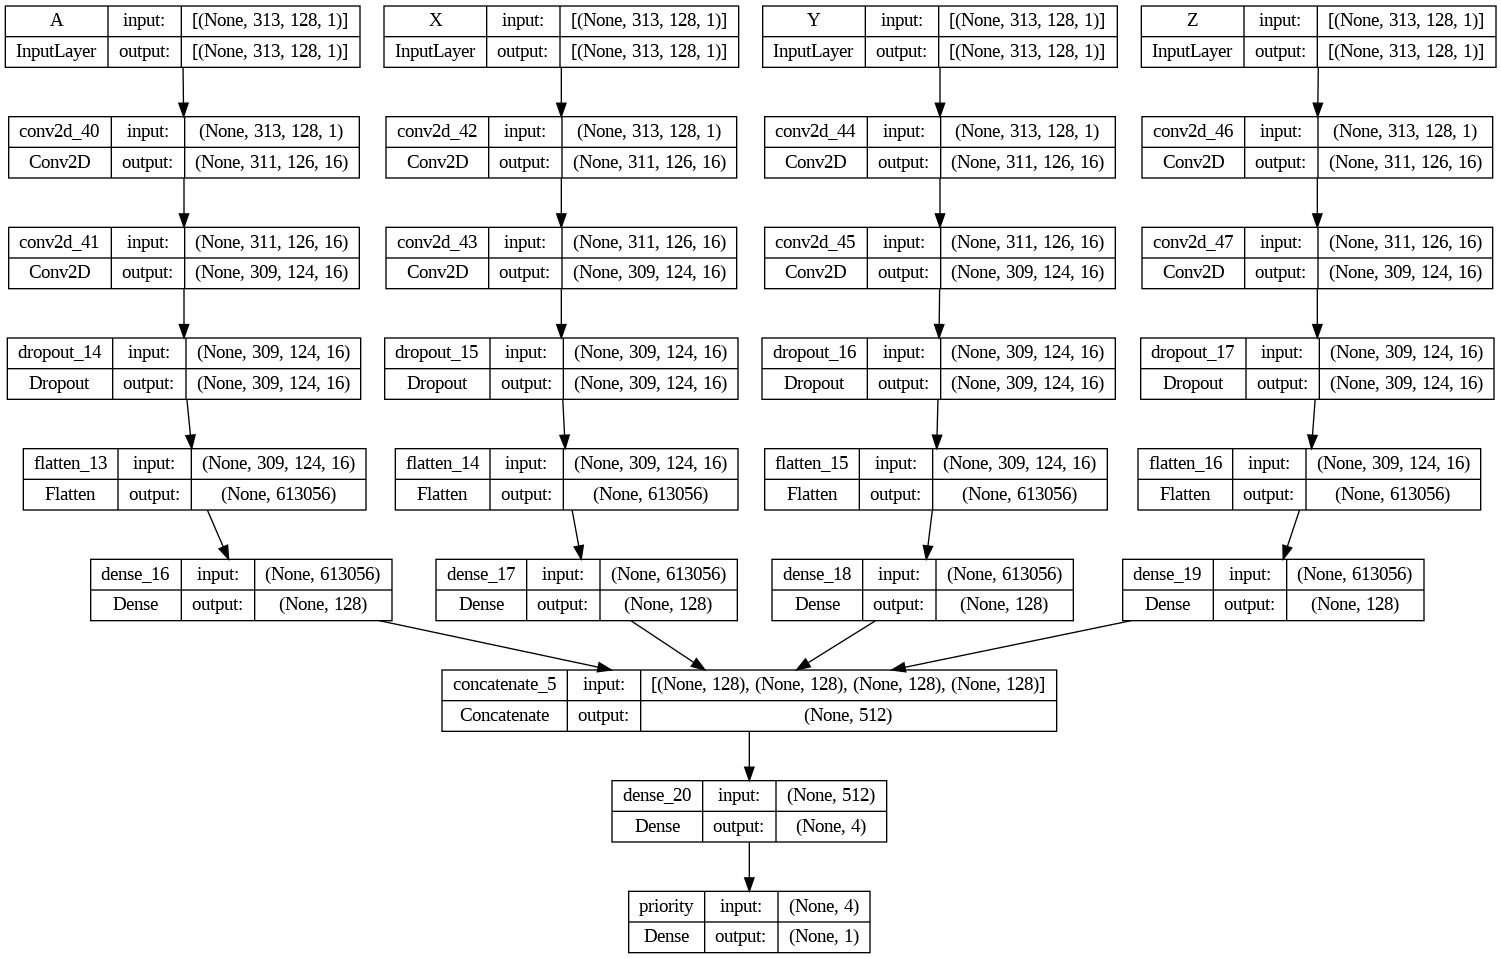

In [28]:
keras.utils.plot_model(modelt, "multi_input_and_output_model.png", show_shapes=True)

In [19]:
combined = concatenate([modelA.output, modelX.output, modelY.output, modelZ.output])
final = Dense(4, activation="relu")(combined)
final = Dense(1, activation="linear")(final)

In [ ]:
print(modelA.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 313, 128, 1), dtype=tf.float32, name='conv2d_11_input'), name='conv2d_11_input', description="created by layer 'conv2d_11_input'")


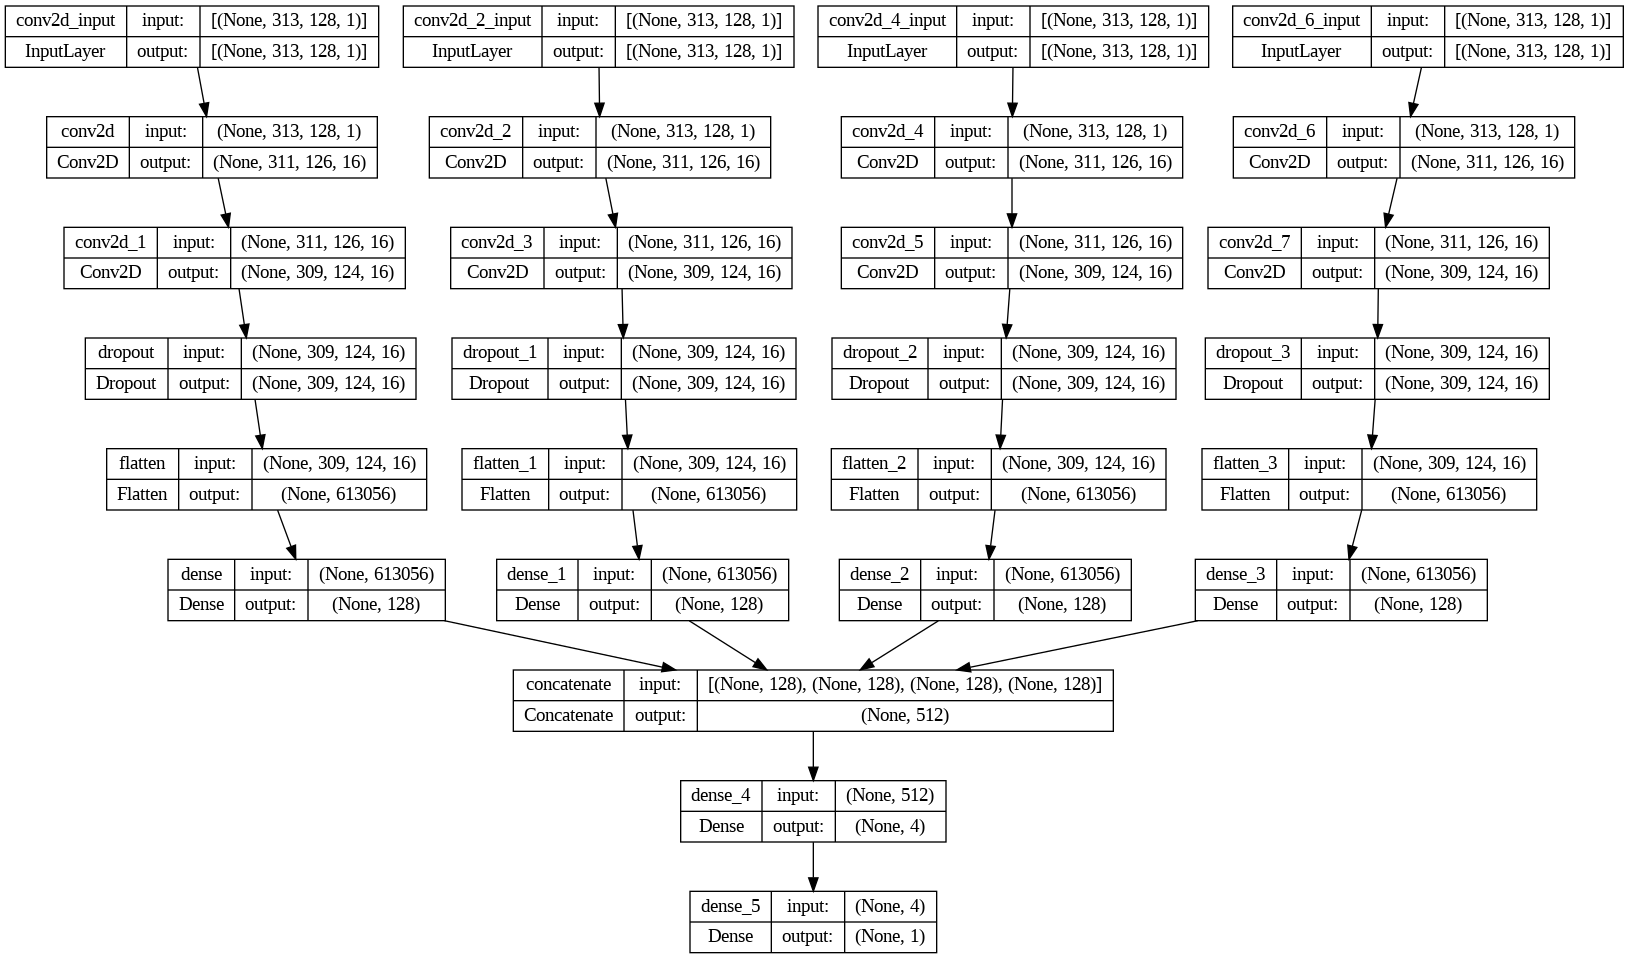

In [29]:
model = Model(inputs=[modelA.input,modelX.input,modelY.input,modelZ.input], 
              outputs=final)
opt = Adam(lr=1e-3)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
#model.summary()
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [40]:
hist = model.fit([trainA, trainX, trainY, trainZ], 
                 epochs=3, 
                 validation_data=[testA, testX, testY, testZ])

ValueError: ignored

In [41]:
samples, labels = trainA.as_numpy_iterator().next()
samples.shape

(16, 313, 128, 1)

In [35]:
hist = model.fit(
    {"A": trainA, "X": trainX, "Y": trainY, "Z":trainZ},
    epochs=3, 
    validation_data=[testA, testX, testY, testZ]
)

ValueError: ignored

In [ ]:
#https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/